In [52]:
#general packages used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pycountry
import re
import os

import re, nltk, spacy, gensim
import nltk.stem
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import random
random.seed(300)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhan.le\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nhan.le\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
#not see annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [54]:
#pre-set defaults for plotting
from matplotlib.pylab import rcParams
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

In [55]:
#read data
data = pd.read_excel(r"C:\NhanLeDocomoDigital\Others\Thesis\Every10years\DataEvery10years.xlsx")
data.head()

,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,...,WC,SC,GA,UT,PM,OA,HC,HP,DA,Column1
0,J,"Lan, T",NaN,NaN,NaN,"Lan, Ting",NaN,NaN,Intrinsic bubbles and Granger causality in the...,FRONTIERS OF BUSINESS RESEARCH IN CHINA,...,Business,Business & Economics,JD9AX,WOS:000490277300001,NaN,DOAJ Gold,NaN,NaN,2019-10-24,NaN
1,J,"Colclough, SN; Moen, O; Hovd, NS; Chan, A",NaN,NaN,NaN,"Colclough, Simon Norheim; Moen, Oystein; Hovd,...",NaN,NaN,SME innovation orientation: Evidence from Norw...,INTERNATIONAL SMALL BUSINESS JOURNAL-RESEARCHI...,...,Business; Management,Business & Economics,IZ3WR,WOS:000487016800002,NaN,NaN,NaN,NaN,2019-10-24,NaN
2,J,"Belhoste, N; Bocquet, R; Favre-Bonte, V; Bally, F",NaN,NaN,NaN,"Belhoste, Nathalie; Bocquet, Rachel; Favre-Bon...",NaN,NaN,How do SMEs use support services during their ...,INTERNATIONAL SMALL BUSINESS JOURNAL-RESEARCHI...,...,Business; Management,Business & Economics,IZ3WR,WOS:000487016800003,NaN,NaN,NaN,NaN,2019-10-24,NaN
3,J,"Cluley, R; Nixon, E",NaN,NaN,NaN,"Cluley, Robert; Nixon, Elizabeth",NaN,NaN,What is an advert? A sociological perspective ...,MARKETING THEORY,...,Business,Business & Economics,IW6FE,WOS:000485071700001,NaN,NaN,NaN,NaN,2019-10-24,NaN
4,J,"Murphy, S; Patterson, M; O'Malley, L",NaN,NaN,NaN,"Murphy, Stephen; Patterson, Maurice; O'Malley,...",NaN,NaN,"Learning how: Body techniques, skill acquisiti...",MARKETING THEORY,...,Business,Business & Economics,IW6FE,WOS:000485071700002,NaN,NaN,NaN,NaN,2019-10-24,NaN


In [56]:
# clean the text, remove unusual symbols, creating new text_clean column

# convert text data to lower case (for easier analysis)
data['TI_clean'] = data['TI'].str.lower()

def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    return cleaned.strip()

# clean text
data['TI_clean'] = data.TI_clean.astype(str).apply(lambda x: clean(x))



In [57]:
# create a unique ID for index
data['ID'] = range(1, len(data.index)+1)
#set index
data = data.set_index('ID')

In [58]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
# simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
data['token'] = list(sent_to_words(data['TI_clean']))

In [59]:
# tockenize text
#data['token'] = data['TI_clean'].apply(word_tokenize)

In [60]:
data['token'][:1]

ID
1    [intrinsic, bubbles, and, granger, causality, ...
Name: token, dtype: object

In [61]:
stop_words = set(stopwords.words('english'))
#"'s" is not included in stopwords, so add "'s" to the set to remove from the cleaned tokens.
stop_words.add("'s")
stop_words.add("'")
stop_words.add("-")
stop_words.add("'")
#I can add more irrelevant words to stopwords to improve my result
data['clean'] = data['token'].apply(lambda x: [w for w in x if not w in stop_words and not w in punctuation])


In [62]:
data = data[['PY','TI','TI_clean','token','clean']]
data.head()

,PY,TI,TI_clean,token,clean
ID,,,,,
1,2019,Intrinsic bubbles and Granger causality in the...,intrinsic bubbles and granger causality in the...,"[intrinsic, bubbles, and, granger, causality, ...","[intrinsic, bubbles, granger, causality, hong,..."
2,2019,SME innovation orientation: Evidence from Norw...,sme innovation orientation evidence from norw...,"[sme, innovation, orientation, evidence, from,...","[sme, innovation, orientation, evidence, norwe..."
3,2019,How do SMEs use support services during their ...,how do smes use support services during their ...,"[how, do, smes, use, support, services, during...","[smes, use, support, services, process, compar..."
4,2019,What is an advert? A sociological perspective ...,what is an advert? a sociological perspective ...,"[what, is, an, advert, sociological, perspecti...","[advert, sociological, perspective, marketing,..."
5,2019,"Learning how: Body techniques, skill acquisiti...","learning how body techniques, skill acquisiti...","[learning, how, body, techniques, skill, acqui...","[learning, body, techniques, skill, acquisitio..."


In [63]:
data['clean'][:1]

ID
1    [intrinsic, bubbles, granger, causality, hong,...
Name: clean, dtype: object

In [64]:
all_per_year = data.groupby('PY').agg({'PY': 'mean', 'clean': 'sum'})
all_per_year.to_csv(r'C:\NhanLeDocomoDigital\Others\Thesis\Every10years\all_per_year.csv', sep='|') 

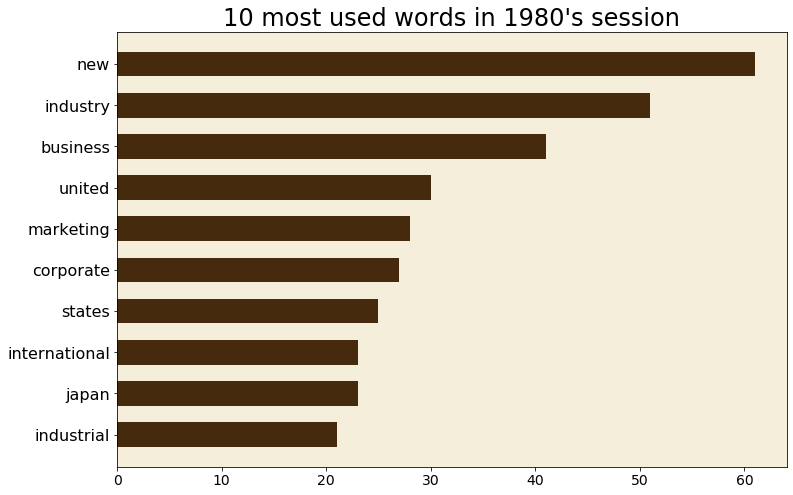

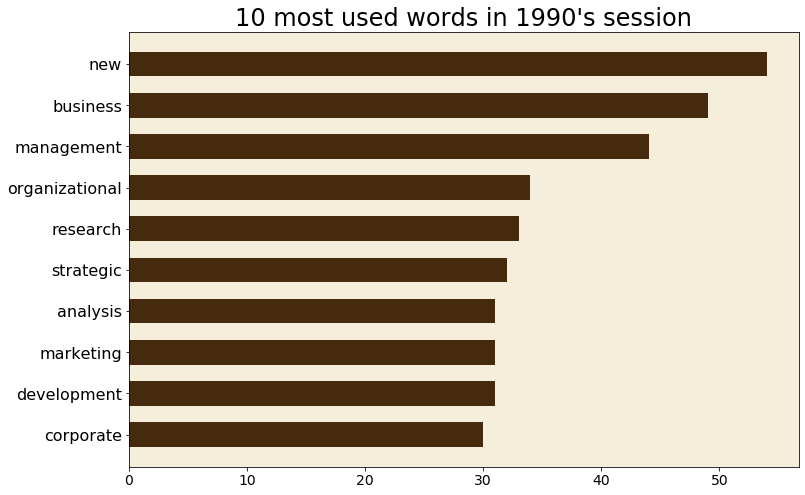

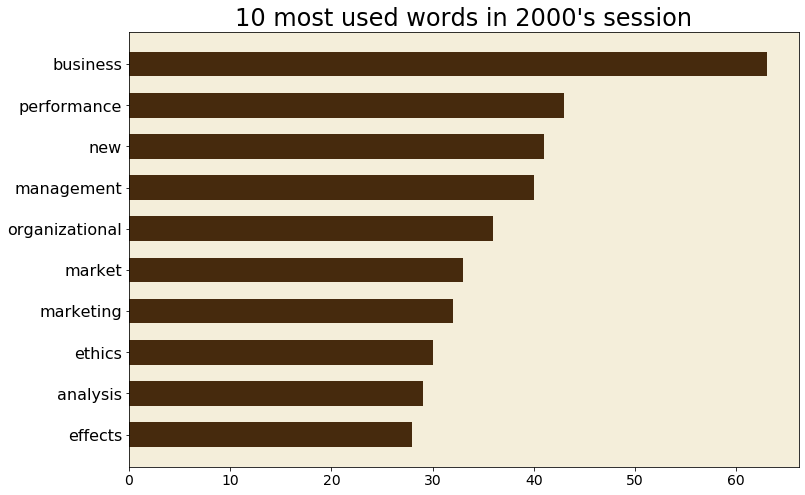

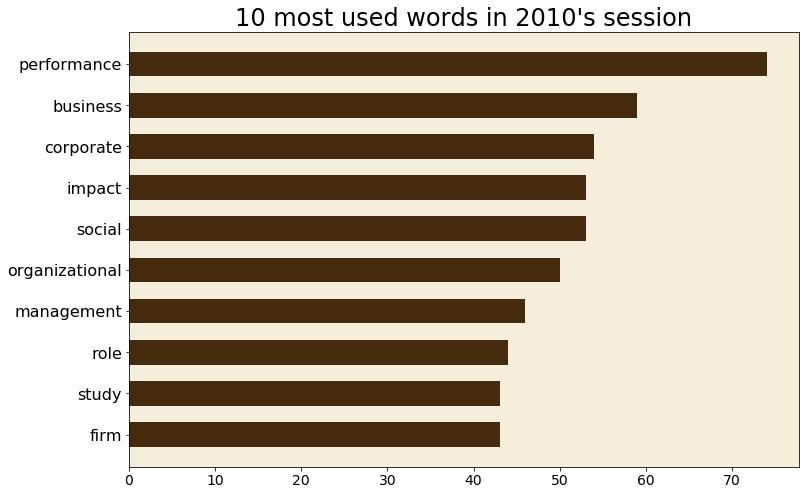

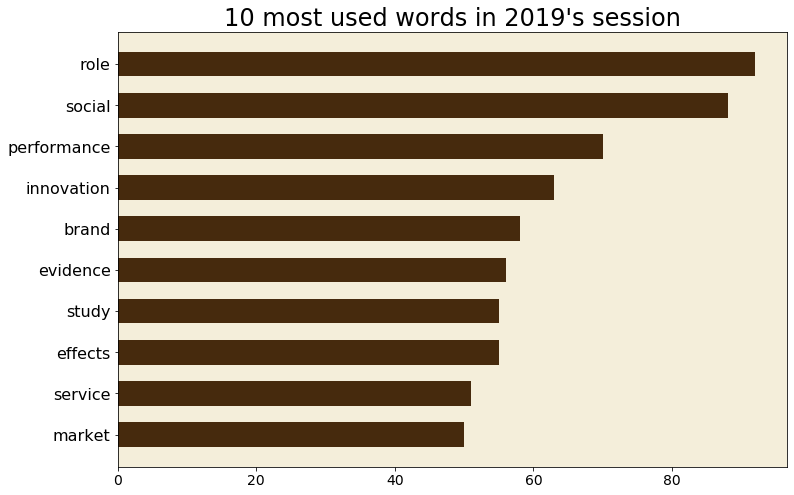

In [67]:
rcParams['figure.figsize'] = 12, 8

for i, row in all_per_year.iterrows():
    sess = dict(nltk.FreqDist(row['clean']))
    sort_sess = sorted(sess.items(), key=lambda x: x[1], reverse=True)[0:10] # choose top 10 words
    plt.barh(range(len(sort_sess)), [val[1] for val in sort_sess], align='center', height=0.6, color='#462a0d')
    plt.yticks(range(len(sort_sess)), [val[0] for val in sort_sess])
    plt.yticks(rotation=0)
    plt.yticks(fontsize=16)
    plt.title("10 most used words in %d's session" % row['PY'],fontsize=24)
    ax = plt.gca()
    ax.set_facecolor('#F4EEDA')
    ax.invert_yaxis() # makes sure it is ordered from most to least
    plt.savefig(r'C:\NhanLeDocomoDigital\Others\Thesis\Every10years\top10words'+str(i)+'.png')
    plt.show()

In [15]:
# get frequencies by year

freqs = {}
for i, speech in data.iterrows():
    year = speech['PY']
    for token in speech['clean']:
        if token not in freqs:
            freqs[token] = {"total_freq":1, year:1}
        else:
            freqs[token]["total_freq"] += 1
            if not freqs[token].get(year):
                freqs[token][year] = 1
            else:
                freqs[token][year] += 1

In [16]:
freqs_df = pd.DataFrame.from_dict(freqs, orient='index')
freqs_df['word'] = freqs_df.index

In [17]:
# Example of data for the word "management"
freqs_df[freqs_df.index == "management"]
#we can see how a particular word (in titles of papers) changed over time.

,total_freq,2019,1990,2000,2010,1980,word
management,191,45.0,44.0,40.0,46.0,16.0,management


In [18]:
new_cols = ["total_freq", "word"] + sorted(freqs_df.columns.tolist()[1:-1])
freqs_df = freqs_df[new_cols]

freqs_df = freqs_df.sort_values('total_freq', ascending=False)

# freqs_df.to_csv('all_per_year_clean.csv', sep='|')

freqs_df.head()

,total_freq,word,1980,1990,2000,2010,2019
business,262,business,41.0,49.0,63.0,59.0,50.0
performance,228,performance,14.0,27.0,43.0,74.0,70.0
new,223,new,61.0,54.0,41.0,43.0,24.0
management,191,management,16.0,44.0,40.0,46.0,45.0
organizational,177,organizational,20.0,34.0,36.0,50.0,37.0


In [19]:
#In titles of papers, the most frequent word is "business" (262 times). See how it changed over times. If we consider that word is irrelevant, 
#I can exclude it by adding it stopword. We consider more interesting words

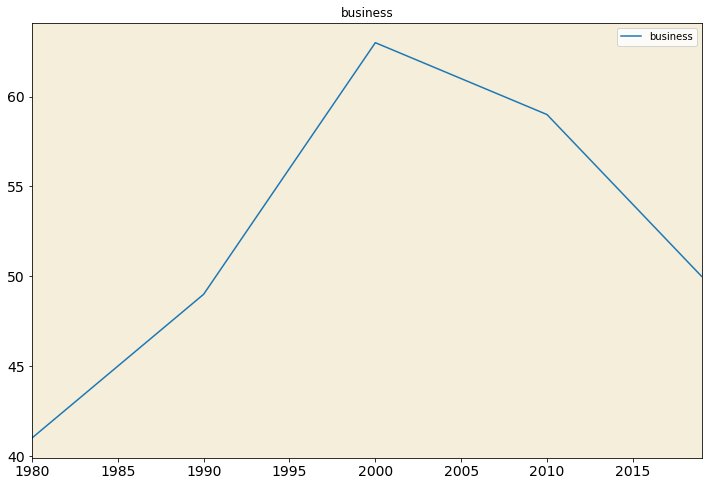

In [20]:
#plot words frequency over time

freqs_df[freqs_df['word'].isin(['business'])].iloc[:, 1:].transpose().iloc[1:].plot(title="business")
axes = plt.gca()
axes.set_facecolor('#F4EEDA')
plt.show()

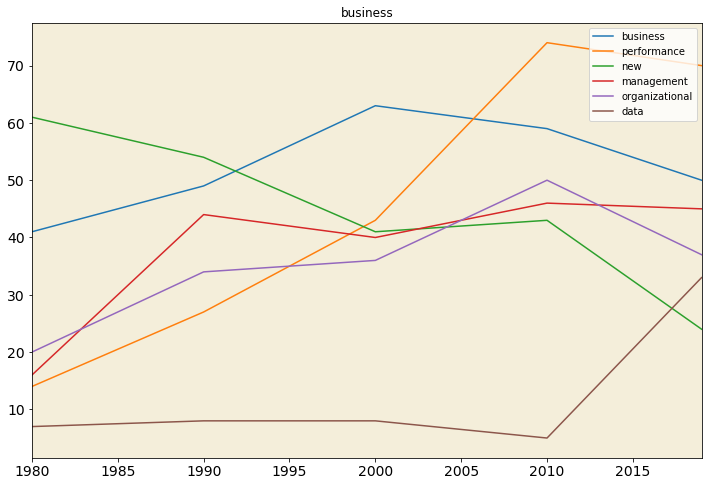

In [21]:
# you can plot words frequency over time

freqs_df[freqs_df['word'].isin(['business', 'performance', 'new', 'management','organizational', 'data'])].iloc[:, 1:].transpose().iloc[1:].plot(title="business")
axes = plt.gca()
axes.set_facecolor('#F4EEDA')
plt.show()

In [22]:
#Dynamic Topic Models (LDA) 

In [23]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):   # lemmatization: achieve the root forms
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [24]:
# Initialize spacy                                  
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data['data_lemmatized'] = lemmatization(data['clean'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data['data_lemmatized'][:2]

ID
1    intrinsic bubble granger causality residential...
2                        evidence norwegian export sme
Name: data_lemmatized, dtype: object

In [25]:
# a document word matrix

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word , at least 10 times
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data['data_lemmatized'])

In [26]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")  #percentage of non-zero datapoints in the document-word matrix (data_vectorized)

Sparsicity:  0.6411558669001751 %


In [27]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [28]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -123401.03775943402
Perplexity:  721.793947308065
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [29]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state=100)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
           

In [30]:
# Best Model
best_lda_model = model.best_estimator_      #model = GridSearchCV

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -45149.191942227335
Model Perplexity:  579.1874851359053


In [31]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = [str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,3
1,0.03,0.03,0.03,0.03,0.55,0.03,0.25,0.03,0.03,0.03,4
2,0.01,0.01,0.01,0.01,0.77,0.01,0.01,0.01,0.01,0.15,4
3,0.03,0.03,0.03,0.03,0.03,0.03,0.7,0.03,0.03,0.03,6
4,0.02,0.18,0.02,0.02,0.02,0.02,0.02,0.52,0.18,0.02,7
5,0.03,0.03,0.03,0.03,0.03,0.03,0.7,0.03,0.03,0.03,6
6,0.02,0.02,0.02,0.57,0.29,0.02,0.02,0.02,0.02,0.02,3
7,0.03,0.34,0.03,0.03,0.03,0.03,0.46,0.03,0.03,0.03,6
8,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,1
9,0.02,0.02,0.02,0.37,0.02,0.02,0.02,0.18,0.33,0.02,3


In [32]:
list_text_PY = data.PY.tolist()
list_text_TI = data.TI.tolist()

In [33]:
df_document_topic["PY"]=list_text_PY
df_document_topic["TI"]=list_text_TI
df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,PY,TI
0,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,3,2019,Intrinsic bubbles and Granger causality in the...
1,0.03,0.03,0.03,0.03,0.55,0.03,0.25,0.03,0.03,0.03,4,2019,SME innovation orientation: Evidence from Norw...
2,0.01,0.01,0.01,0.01,0.77,0.01,0.01,0.01,0.01,0.15,4,2019,How do SMEs use support services during their ...
3,0.03,0.03,0.03,0.03,0.03,0.03,0.70,0.03,0.03,0.03,6,2019,What is an advert? A sociological perspective ...
4,0.02,0.18,0.02,0.02,0.02,0.02,0.02,0.52,0.18,0.02,7,2019,"Learning how: Body techniques, skill acquisiti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0,1980,"PSYCHOANALYZING CARTER,JIMMY"
4996,0.03,0.03,0.70,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2,1980,UPBEAT OUTLOOK FOR FAMILY INCOMES
4997,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,6,1980,THE DOWN-HOME CHAMPS OF JOCKWEAR
4998,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0,1980,ROTAN MOSLE - ITS UP ON OIL


In [34]:
#show topic distribution
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,861
1,3,627
2,1,507
3,2,506
4,8,506
5,5,428
6,6,422
7,4,420
8,7,376
9,9,347


In [35]:
pyLDAvis.enable_notebook()  
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      218.483337  -36.499805       1        1  12.835883
3       60.943214  -68.428795       2        1  11.562505
1      132.474350 -188.533524       3        1  10.651891
2     -119.107109  144.224594       4        1  10.486447
4       36.467537  198.294983       5        1   9.785062
9      -52.437057 -160.084579       6        1   9.722874
6      214.091019  139.986237       7        1   9.640172
7       96.497055   64.506187       8        1   9.288085
5      -36.506340   28.623163       9        1   8.322359
0     -162.136795  -38.485500      10        1   7.704723, topic_info=    Category        Freq         Term       Total  loglift  logprob
386  Default  221.000000  performance  221.000000  30.0000  30.0000
329  Default  220.000000       market  220.000000  29.0000  29.0000
103  Default  201.000000     consumer  201.000000  28.0000  28.0000
109  Default  168.000000    corporate  168.000000  27.0000  27.0000
54   Default  251.000000     business  251.000000  26.0000  26.0000
..       ...         ...          ...         ...      ...      ...
332  Topic10   14.862386       matter   30.919918   1.8308  -4.5767
492  Topic10   17.239501       social  147.151138   0.4191  -4.4284
462  Topic10   17.299022         role  156.187196   0.3629  -4.4249
71   Topic10   16.159559       change  105.775269   0.6845  -4.4930
566  Topic10   13.574322         work  108.294004   0.4867  -4.6674

[497 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         8  0.960027   accounting
2         1  0.029271  acquisition
2         8  0.936670  acquisition
5         3  0.838524     adoption
5         7  0.119789     adoption
...     ...       ...          ...
568       7  0.178135        world
568      10  0.734808        world
569      10  0.958192         year
570       5  0.829406        young
570      10  0.092156        young

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 2, 3, 5, 10, 7, 8, 6, 1])

In [36]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,academic,accounting,acquisition,action,activity,adoption,advantage,advertisement,advertising,affect,...,web,well,win,woman,word,work,worker,world,year,young
Topic0,0.100008,0.100011,0.100002,9.697414,0.100008,0.100002,0.100002,0.100004,0.100008,0.100014,...,1.172436,0.100004,18.099965,0.100020,0.100006,13.532509,2.308660,32.783341,24.099958,1.246855
Topic1,0.100008,0.100000,0.100004,0.100011,7.409933,21.704739,0.100010,0.100003,0.100003,0.104004,...,0.100002,0.100002,0.100001,0.100007,2.402900,0.114377,15.080137,0.166513,0.100002,0.100014
Topic2,0.100005,0.100004,0.100003,0.293804,5.516786,0.100009,0.100001,10.100010,64.667193,0.100009,...,0.100002,18.100170,0.100001,18.069833,3.315354,0.100012,0.100003,0.100009,0.100001,0.100008
Topic3,7.588132,0.100003,0.175038,0.100002,0.100015,0.441574,0.100005,0.100004,0.100005,7.446729,...,0.100000,0.100014,0.100019,0.100008,0.100014,0.100008,0.100006,0.100009,0.100004,0.100007
Topic4,0.100005,0.100000,0.100005,0.103498,8.771277,0.100009,0.100001,0.100003,0.100001,0.100006,...,0.100005,0.100006,0.100007,0.100007,6.581675,10.930532,0.100022,0.619493,0.100008,8.953106


In [37]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,good,practice,big,management,manager,datum,entrepreneurial,world,bank,behavior,value,top,leader,year,opportunity
Topic 1,consumer,product,strategy,influence,impact,analysis,environmental,ethical,choice,sale,study,business,perception,firm,brand
Topic 2,brand,effect,stock,advertising,consumer,attitude,role,global,get,family,cost,return,system,online,market
Topic 3,market,business,new,industry,development,process,future,product,ethic,public,emerge,need,relation,share,power
Topic 4,corporate,company,social,study,organization,responsibility,problem,evidence,change,analysis,sector,japanese,exploratory,economy,examination
Topic 5,work,chain,manage,case,supply,strategic,time,dynamic,design,project,investor,life,view,management,conflict
Topic 6,marketing,business,technology,medium,perspective,enterprise,small,research,country,social,firm,policy,international,application,base
Topic 7,decision,make,investment,foreign,leadership,structure,acquisition,state,strategy,planning,strategic,firm,ethical,risk,system
Topic 8,performance,organizational,firm,role,job,model,economic,relationship,knowledge,effect,level,learn,financial,analysis,commitment
Topic 9,service,customer,quality,price,network,employee,use,affect,innovation,value,perspective,management,online,satisfaction,effect


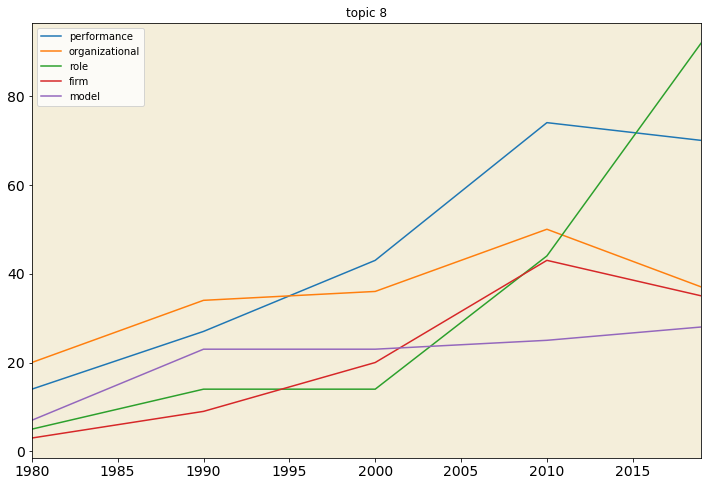

In [38]:
# topic 8: 
freqs_df[freqs_df['word'].isin(['performance', 'organizational', 'firm', 'role',"model"])].iloc[:, 1:].transpose().iloc[1:].plot(title="topic 8")
axes = plt.gca()
axes.set_facecolor('#F4EEDA')
plt.show()

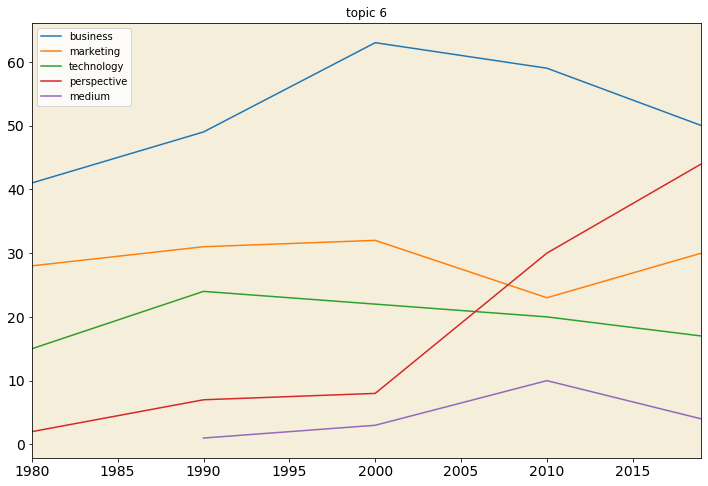

In [39]:
# topic 6: 
freqs_df[freqs_df['word'].isin(['marketing', 'business', 'technology', 'medium', 'perspective'])].iloc[:, 1:].transpose().iloc[1:].plot(title="topic 6")
axes = plt.gca()
axes.set_facecolor('#F4EEDA')
plt.show()

In [40]:
titles_paragraphs=data
titles_paragraphs['TI']=titles_paragraphs['data_lemmatized']

In [41]:
# creating subset of just "social" and "innovation"

text_social = titles_paragraphs[titles_paragraphs['TI'].str.contains("social")]
text_innovation = titles_paragraphs[titles_paragraphs['TI'].str.contains("innovation")]
frames = [text_social, text_innovation]
titles_socialinnovation = pd.concat(frames)

# text_social.to_csv('text_social.csv', sep='|') 

titles_socialinnovation.shape

(287, 6)

In [42]:
titles_socialinnovation.head()

,PY,TI,TI_clean,token,clean,data_lemmatized
ID,,,,,,
19,2019,drive sustainability orient innovation organiz...,driving sustainability oriented innovation org...,"[driving, sustainability, oriented, innovation...","[driving, sustainability, oriented, innovation...",drive sustainability orient innovation organiz...
29,2019,consumer brand experience social medium improv...,how consumers' brand experience in social medi...,"[how, consumers, brand, experience, in, social...","[consumers, brand, experience, social, media, ...",consumer brand experience social medium improv...
33,2019,social marketing role improve water quality gr...,social marketing's role in improving water qua...,"[social, marketing, role, in, improving, water...","[social, marketing, role, improving, water, qu...",social marketing role improve water quality gr...
83,2019,long wind complex social innovation network,the long and winding road building legitimacy...,"[the, long, and, winding, road, building, legi...","[long, winding, road, building, legitimacy, co...",long wind complex social innovation network
102,2019,service recovery stage effect social medium re...,service recovery on stage effects of social m...,"[service, recovery, on, stage, effects, of, so...","[service, recovery, stage, effects, social, me...",service recovery stage effect social medium re...


In [43]:
text_social_2010 = titles_socialinnovation[titles_socialinnovation['PY']== 2010]

In [44]:
text_social_2010.shape

(93, 6)

In [45]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from palettable.matplotlib import Inferno_8
import random

In [46]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Inferno_8.colors[random.randint(1,6)])

In [47]:
text_social_2010[["TI"]].head()

,TI
ID,
1014,empirical study relationship business ethic so...
1091,emotional exhaustion employee social client co...
1101,social effect internet auction informativity e...
1107,know know role intellectual social capital opp...
1136,performance implication retail purchase networ...


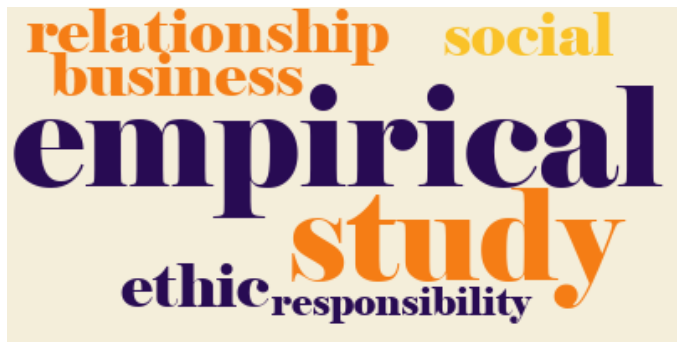

In [48]:
# we can see, what paper ID 1014 said 

text1 = text_social_2010.TI[1014]

wordcloud = WordCloud(font_path='../input/truefont/ELEPHNT.TTF', background_color="#F4EEDA").generate(text1)
wordcloud.recolor(color_func=color_func, random_state=2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

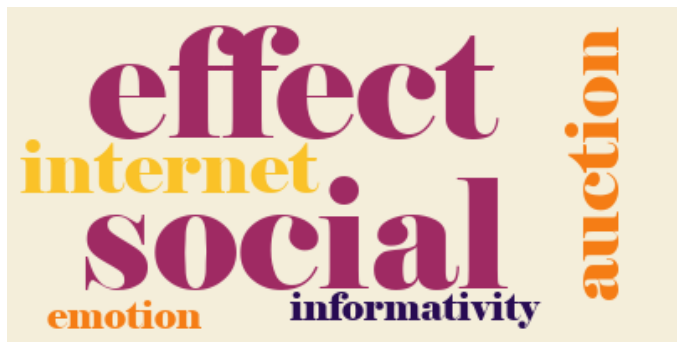

In [49]:
# we can see, what paper ID 1101 said 
text1 = text_social_2010.TI[1101]

wordcloud = WordCloud(font_path='../input/truefont/ELEPHNT.TTF', background_color="#F4EEDA").generate(text1)
wordcloud.recolor(color_func=color_func, random_state=2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

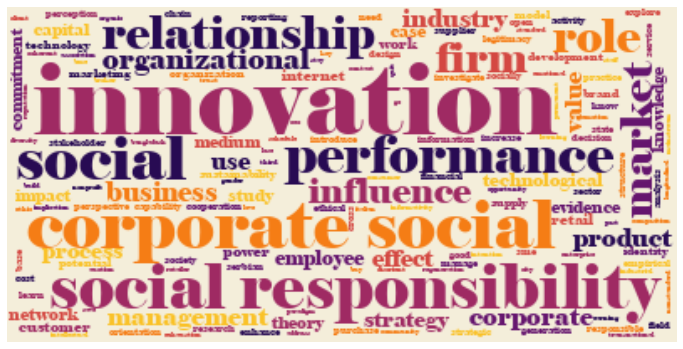

In [50]:
#we can see, what all papers in 2010 said 

text2 = " ".join(debate for debate in text_social_2010.TI)

wordcloud = WordCloud(font_path='../input/truefont/ELEPHNT.TTF', background_color="#F4EEDA").generate(text2)

wordcloud.recolor(color_func=color_func, random_state=2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

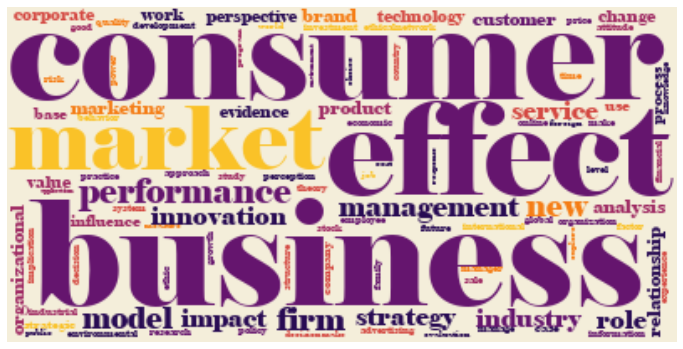

In [51]:
#we can see, what all papers in data said 

text3 = " ".join(debate for debate in titles_paragraphs.TI)

wordcloud = WordCloud(font_path='../input/truefont/ELEPHNT.TTF', background_color="#F4EEDA").generate(text3)

wordcloud.recolor(color_func=color_func, random_state=2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()